**Note:** This notebook requires interactions with the `Duet and TenSEAL - Data Scientist` notebook, so make sure you run the appropriate commands on the other side when needed. It would be even better if you could do that with a friend, located somewhere else in the world, playing the role of a data scientist.

The goal is to perform a machine learning evaluation on encrypted data. The data owner encrypts and send a data point from the test set to the data scientist, who will perform an evaluation without giving away his model. The encrypted result will be then sent back to the data owner.

We start by launching Duet. The data scientist is expected to join the Duet session after that.

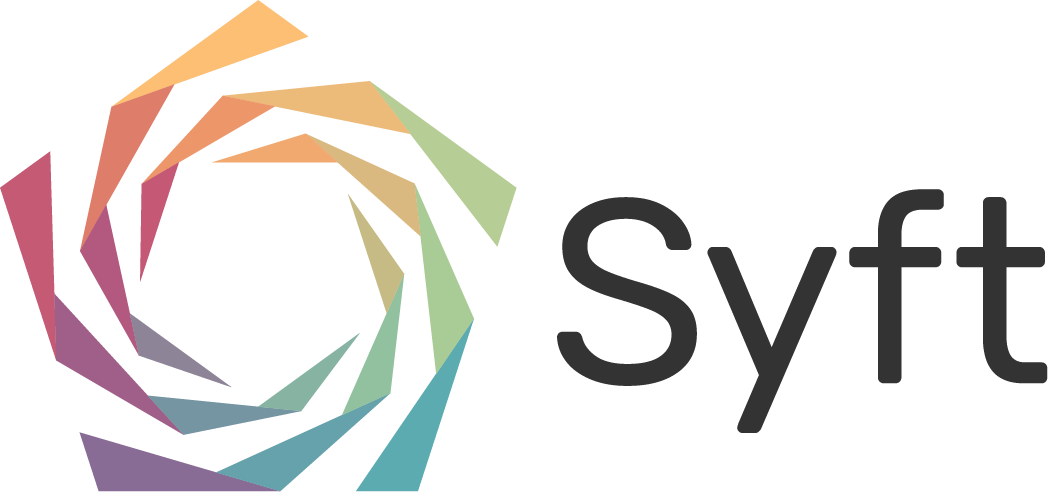

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!
♫♫♫ > Duet Server ID: 2d18b0afe778ac9ef381a3bd85f1c753

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.duet("2d18b0afe778ac9ef381a3bd85f1c753")

♫♫♫ > STEP 2: Ask your partner for their Client ID and enter it below!
♫♫♫ > Duet Partner's Client ID: 
    > Error: Invalid Client ID. Please try again.
♫♫♫ > Duet Partner's Client ID: 7f94259bfc8b33644b9e16b0329a569d

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!



In [1]:
import tenseal as ts
import torch as th
import syft as sy

sy.load_lib("tenseal")

# run this if you are doing this locally
# duet = sy.launch_duet(loopback=True)

duet = sy.launch_duet()

We will use the same data set as the previous notebook. We will only need to sample a random instance from the test set for evaluation. So let's load the test set, and get a single instance to use later for evaluation.

In [2]:
test_X = th.load("data/test_X.pt")
rand_x_idx = th.randint(test_X.shape[0], (1,))
x = test_X[rand_x_idx].squeeze(0)
x.shape

torch.Size([1024])

Now we create the TenSEAL context for our encrypted computation, and encrypt our instance x before sending it to the data scientist. We will also need to send the context to let him perform the computation.

In [3]:
# Parameters
bits_scale = 25
coeff_mod_bit_sizes = [30, bits_scale, bits_scale, bits_scale, 30]
polynomial_modulus_degree = 8192

# Create context
context = ts.context(ts.SCHEME_TYPE.CKKS, polynomial_modulus_degree, coeff_mod_bit_sizes=coeff_mod_bit_sizes)
# Set global scale
context.global_scale = 2 ** bits_scale
# Generate galois keys required for matmul in ckks_vector
context.generate_galois_keys()

In [4]:
enc_x = ts.ckks_vector(context, x)

In [5]:
# Making them available to be fetched by the data scientist
context_ptr = context.send(duet, searchable=True, tags=["ctx"])
enc_x_ptr = enc_x.send(duet, searchable=True, tags=["enc_x"])

In [6]:
duet.store.pandas

ID     Tags Description
0  <UID: 72631a6ad9164e0f9a04b70f57fb5469>    [ctx]            
1  <UID: bf4a3dd48ee34f2a93945ab8fe202f52>  [enc_x]

At this point, the data scientist will request access to these objects. We need to grant him that access so that he can compute on them.

In [7]:
duet.requests.pandas

Name Reason  \
0             I want to get the context          
1  I want to get the encrypted instance          

                                Request ID  \
0  <UID: a67a65caa7d1429dbe822577609ff687>   
1  <UID: 7b8b010beb234835852e320ca7cd38b9>   

                     Requested Object's ID  
0  <UID: 72631a6ad9164e0f9a04b70f57fb5469>  
1  <UID: bf4a3dd48ee34f2a93945ab8fe202f52>

In [8]:
# accepting both
duet.requests[0].accept()
duet.requests[0].accept()

At this point, the data scientist should have done the encrypted evaluation and send us back the encrypted result.

In [9]:
duet.store.pandas

ID                Tags Description
0  <UID: a0856a3b208f4a4199d53906d1631db6>  [encrypted_result]

In [10]:
encrypted_result_ptr = duet.store["encrypted_result"]
encrypted_result = encrypted_result_ptr.get()
encrypted_result.link_context(context)

In [11]:
def compute_labels(out):
    out = th.sigmoid(out)
    return (out >= 0.5).int()

result = encrypted_result.decrypt()
compute_labels(th.tensor(result))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)